# Locating Identifier: POS Tagging

In [1]:
import spacy
import en_core_web_sm
import pandas as pd
import matplotlib.pyplot as plt

spaCy linguistic features: https://spacy.io/usage/linguistic-features#pos-tagging

In [2]:
#load the part of speech tagger
nlp = en_core_web_sm.load()

In [3]:
df = pd.read_csv('data/Augmented_Data.csv')
df

,Text Command,Topic,Identifier,Action,One Hot Encoded Topic,One Hot Encoded Action,Verb/Noun
0,critique Track trends,Task,Track trends,In Review,"[1,0]","[0,0,1,0,0]",SYNREPLACED
1,assign tax Track trends in progress,Task,Track trends,In Progress,"[1,0]","[0,1,0,0,0]",SYNREPLACED
2,Track trends chore is completed,Task,Track trends,Completed,"[1,0]","[0,0,0,0,1]",SYNREPLACED
3,create a new Track trends chore,Task,Track trends,To Do,"[1,0]","[1,0,0,0,0]",SYNREPLACED
4,Track trends fall to orbit,Project,Track trends,On Target,"[0,1]","[0,1,0,0,0]",SYNREPLACED
...,...,...,...,...,...,...,...
2985,create a green Evaluate profits,Task,Evaluate profits,To Do,"[1,0]","[1,0,0,0,0]",SYNREPLACED
2986,assign Evaluate profits in advance,Task,Evaluate profits,In Progress,"[1,0]","[0,1,0,0,0]",SYNREPLACED
2987,see Evaluate profits at risk,Project,Evaluate profits,At Risk,"[0,1]","[0,0,1,0,0]",SYNREPLACED
2988,out of use task Evaluate profits,Task,Evaluate profits,Blocked,"[1,0]","[0,0,0,1,0]",SYNREPLACED


## EDA to Develop Rules

In [4]:
#create dataframe for adding tag data
identifier_pos = pd.DataFrame(columns = ['Text Command', 'Identifier', 'Tag Start', 'Tag End', 'First Tag', 'Last Tag'])

### POS Tagging

In [59]:
"""
This method finds the POS of the first word in the sentence (Tag Start), last word of the
sentence (Tag End), the word preceding the identifier (First Tag), and the word that comes
right after the identifier (Last Tag).
"""
for i in df.index.values:
    #convert sentence into list of words with tags associated to each word
    sentence = nlp(df.loc[i][0])
    #create list of words that make up identifier
    identifier = df.loc[i][2].split()
    #first word in the identifier
    identifier_start = identifier[0]
    #last word in the identifier
    identifier_end = identifier[-1]
    #intialize the start of sentence tag
    last_word = nlp('SS')
#     for token in last_word:
#         #last word starts as SS token
#         last_word = token
    #intialize the tag after the identifier as None
    tag_end = None
    #iterate through the words in the text command
    for j in range(len(sentence)):
        token = sentence[j]
        #if the word is equal to the first word in the identifer...
        if token.text == identifier_start:
            #if the last word variable is still the SS token then the tag that starts the identifier is the
            #start of the sentence
            if last_word.text == 'SS':
                tag_start = 'SS'
            #if not then the start tag is the POS tag of the last checked word
            else:
                tag_start = last_word.tag_
        #if the word is equal to the last word in the identifier...
        if last_word.text == identifier_end:
            tag_end = token.tag_
        #check the POS tag of the first word in the sentence
        if j == 0:
            if token.text == identifier_start:
                first_tag = 'ID'
            else:
                first_tag = token.tag_
        #check the POS tag of the last word in the sentence
        if j == len(sentence)-1:
            if token.text == identifier_end:
                last_tag = 'ID'
            else:
                last_tag = token.tag_
        #save the current word as last word for the above conditionals 
        last_word = token
    #if tag end hasn't been updated then we know that the identifier is at the end of the sentence
    if tag_end == None:
        tag_end = 'ES'
    identifier_pos.loc[i] = [str(sentence), df.loc[i][2], tag_start, tag_end, first_tag, last_tag]
    print('Commands tagged: ' + str(i), end='\r')

In [6]:
identifier_pos

,Text Command,Identifier,Tag Start,Tag End,First Tag,Last Tag
0,critique Track trends,Track trends,NNP,ES,NNP,ID
1,assign tax Track trends in progress,Track trends,NN,IN,NNP,NN
2,Track trends chore is completed,Track trends,SS,NN,ID,VBN
3,create a new Track trends chore,Track trends,JJ,NN,VB,NN
4,Track trends fall to orbit,Track trends,SS,VBP,ID,NN
...,...,...,...,...,...,...
2985,create a green Evaluate profits,Evaluate profits,JJ,ES,VB,ID
2986,assign Evaluate profits in advance,Evaluate profits,NNP,IN,NNP,NN
2987,see Evaluate profits at risk,Evaluate profits,VB,IN,VB,NN
2988,out of use task Evaluate profits,Evaluate profits,NN,ES,IN,ID


### Descriptive Analytics

In [7]:
"""
This method finds the counts of each tab combo
"""
#intialize the dictionaries that contain counts of POS tags associated with text commands
tag_start_dict = dict()
tag_end_dict = dict()
tag_combo_dict = dict()
first_tag_dict = dict()
last_tag_dict = dict()
first_last_combo_dict = dict()
for i in range(len(identifier_pos.index)):
    tag_start = identifier_pos.loc[i][2]
    tag_end = identifier_pos.loc[i][3]
    #string combination of the two tags that the identifier is between
    tag_combo = tag_start + '-' + tag_end
    #POS tag of the first word in text command
    first_tag = identifier_pos.loc[i][4]
    last_tag = identifier_pos.loc[i][5]
    #string combination of first and last tag
    first_last_combo = first_tag + '-' + last_tag
    #update counts of text commands where POS tag indicates start of identifier
    if tag_start_dict.get(tag_start,0) == 0:
        tag_start_dict[tag_start] = 1
    else:
        tag_start_dict[tag_start] += 1
    #same thing but for end of identifier 
    if tag_end_dict.get(tag_end,0) == 0:
        tag_end_dict[tag_end] = 1
    else:
        tag_end_dict[tag_end] += 1
    #update counts of text commands where identifier is between combo of start and end POS tags
    if tag_combo_dict.get(tag_combo,0) == 0:
        tag_combo_dict[tag_combo] = 1
    else:
        tag_combo_dict[tag_combo] += 1
    #update counts of text commands with a nested dictionary. Keys in the outer dictionary are the POS tag assigned
    #to the first word in the text command. Key in the inner dictionary is the combo of start and end POS tags
    if first_tag_dict.get(first_tag,0) == 0:
        first_tag_dict[first_tag] = dict()
        first_tag_dict[first_tag][tag_combo] = 1
    else:
        if first_tag_dict[first_tag].get(tag_combo,0) == 0:
            first_tag_dict[first_tag][tag_combo] = 1
        else:
            first_tag_dict[first_tag][tag_combo] += 1
        tag_combo_dict[tag_combo] += 1
    #same for the last word in the text command
    if last_tag_dict.get(last_tag,0) == 0:
        last_tag_dict[last_tag] = dict()
        last_tag_dict[last_tag][tag_combo] = 1
    else:
        if last_tag_dict[last_tag].get(tag_combo,0) == 0:
            last_tag_dict[last_tag][tag_combo] = 1
        else:
            last_tag_dict[last_tag][tag_combo] += 1
    #same for the combo of the first and last word in the text command 
    if first_last_combo_dict.get(first_last_combo,0) == 0:
        first_last_combo_dict[first_last_combo] = dict()
        first_last_combo_dict[first_last_combo][tag_combo] = 1
    else:
        if first_last_combo_dict[first_last_combo].get(tag_combo,0) == 0:
            first_last_combo_dict[first_last_combo][tag_combo] = 1
        else:
            first_last_combo_dict[first_last_combo][tag_combo] += 1

In [8]:
#sorted dictionary of the text commands where the first and last words in the text command are nouns
sorted_combo_tag_dict = {k: v for k, v in sorted(first_last_combo_dict['VBN-ID'].items(), key=lambda item: item[1],reverse=True)}

<BarContainer object of 8 artists>

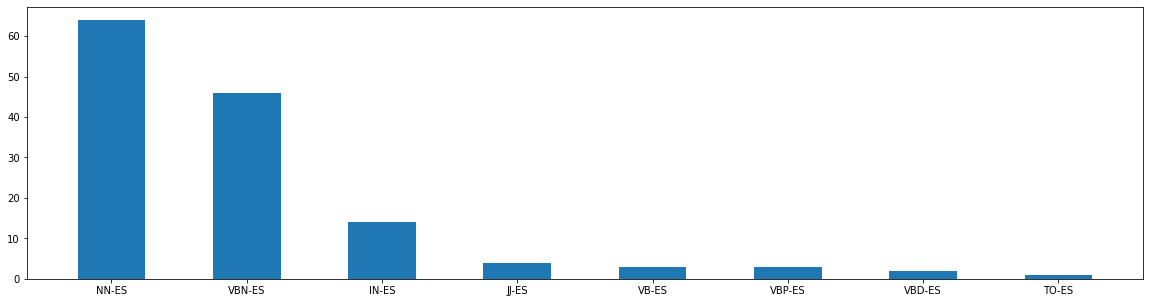

In [9]:
#visualize the number of text commands with a certain start end POS combo for the above condition
plt.figure(figsize=(20,5))
plt.bar(list(sorted_combo_tag_dict.keys()),list(sorted_combo_tag_dict.values()),width=0.5)

### Rule Creation

In [11]:
#applys the rule where if the text command starts and ends with a noun then we look for the first instance
#of a noun, then every word after is included in the identifier until a noun, preposition, or verb is found
def IdentifierIdentifier(pos_tagger,text_command):
    sentence = pos_tagger(text_command)
    first_tag = sentence[0].tag_
    last_tag = sentence[-1].tag_
    first_idx = None
    last_idx = None
    identifier_start = False
#     if first_tag == 'NN' and last_tag == 'NN':
#         for i in range(len(sentence)):
#             tag = sentence[i].tag_
#             if identifier_start and (tag == 'IN' or tag == 'VBZ' or tag == 'NN'):
#                 if tag == 'NN':
#                     last_idx = i+1
#                 else:
#                     last_idx = i
#                 break
#             if not identifier_start and tag == 'NN':
#                 first_idx = i
#                 identifier_start = True
    if first_tag == 'VBN':
        for i in range(len(sentence)):
            tag = sentence[i].tag_
            if i+1 <= len(sentence)-1:
                next_tag = sentence[i+1].tag_
            else:
                next_tag = None
            if (tag == 'IN' and next_tag == 'NN') or ((tag == 'NN' and next_tag == 'IN') or (tag == 'NN' and next_tag == 'VBN')):
                first_idx = i+2
                break
            if (tag == 'NN' or tag == 'IN'):
                first_idx = i+1
                break
        last_idx = len(sentence)
        
    identifier = sentence[first_idx:last_idx]
    return identifier

## Testing Rules

In [12]:
def print_tags(pos_tagger,text_command):
    sentence = pos_tagger(text_command)
    lst = []
    for word in sentence:
        lst.append(word.tag_)
    return str(sentence),lst

In [50]:
new_df = identifier_pos[(identifier_pos['Last Tag'] == 'ID') & (identifier_pos['First Tag'] == 'VBN')]
count = 0
print('Commands misclassified: ')
print('---')
for i in new_df.index.values:
    text_command = new_df.loc[i][0]
    identifier = new_df.loc[i][1]
    predicted_identifier = IdentifierIdentifier(nlp, text_command)
    if str(predicted_identifier) == identifier:
        count += 1
    else:
        print(print_tags(nlp,text_command)[0] + ', '+str(print_tags(nlp,text_command)[1])+', ' + str(predicted_identifier))
print('---')
print('Rule accuracy: ', count/len(new_df.index.values)) 

Commands misclassified: 
---
put on target to task Track trends, ['VBN', 'RP', 'NN', 'IN', 'NN', 'NNP', 'NNS'], task Track trends
created project known as Track trends, ['VBN', 'NN', 'VBN', 'IN', 'NNP', 'NNS'], as Track trends
put in review to task Track trends, ['VBN', 'IN', 'NN', 'IN', 'NN', 'NNP', 'NNS'], to task Track trends
completed cast Track trends, ['VBN', 'VBN', 'NNP', 'NNS'], completed cast Track trends
put in progress to task Track trends, ['VBN', 'IN', 'NN', 'IN', 'NN', 'NNP', 'NNS'], to task Track trends
created task known as Monitor competition, ['VBN', 'NN', 'VBN', 'IN', 'NNP', 'NN'], as Monitor competition
consummated Monitor competition, ['VBN', 'NNP', 'NN'], 
put in progress to Monitor competition, ['VBN', 'IN', 'NN', 'IN', 'NNP', 'NN'], to Monitor competition
done Monitor competition, ['VBN', 'NNP', 'NN'], 
realized Plan campaign, ['VBN', 'NNP', 'NN'], 
created see called Plan campaign, ['VBN', 'VBP', 'VBN', 'NNP', 'NN'], 
offset with Plan campaign, ['VBN', 'IN', 'N

## Generic Rule Generator (UNFINISHED)

In [15]:
first_last_combo_totals = dict()
for key in first_last_combo_dict.keys():
    first_last_combo_totals[key] = sum(first_last_combo_dict[key].values())
#sorted dictionary of the text commands where the first and last words in the text command are nouns
first_last_combo_totals = {k: v for k, v in sorted(first_last_combo_totals.items(), key=lambda item: item[1],reverse=True)}
first_last_combo_totals

{'ID-NN': 568,
 'VB-ID': 318,
 'NNP-NN': 278,
 'NN-NN': 260,
 'VB-NN': 186,
 'NNP-ID': 157,
 'VBN-ID': 137,
 'NN-ID': 82,
 'ID-JJ': 81,
 'IN-ID': 77,
 'VBN-NN': 77,
 'JJ-ID': 69,
 'ID-VBN': 68,
 'PRP-ID': 55,
 'IN-NN': 43,
 'NN-JJ': 41,
 'VBD-NN': 37,
 'NN-VBN': 36,
 'JJ-NN': 33,
 'VBD-ID': 26,
 'ID-VBD': 24,
 'NNP-VB': 23,
 'ID-RB': 21,
 'EX-ID': 18,
 'VBG-ID': 18,
 'VBG-NN': 17,
 'VB-VBN': 15,
 'EX-NN': 13,
 'VB-VB': 13,
 'NN-VBD': 13,
 'NNP-JJ': 12,
 'ID-NNS': 12,
 'NNP-NNP': 11,
 'NNP-VBN': 11,
 'ID-NNP': 10,
 'VB-JJ': 10,
 'ID-DT': 9,
 'JJ-NNS': 7,
 'NNP-VBD': 7,
 'NNP-NNS': 6,
 'NN-RB': 6,
 'NNS-ID': 6,
 'ID-RP': 5,
 'NNP-RP': 5,
 'ID-VB': 5,
 'NNP-VBP': 4,
 'NN-VBP': 4,
 'VBN-VB': 4,
 'NN-VB': 4,
 'NN-DT': 4,
 'NN-RP': 3,
 'VB-VBP': 3,
 'ID-IN': 3,
 'VBN-VBP': 2,
 'VBP-NN': 2,
 'VBD-NNS': 2,
 'ID-VBP': 2,
 'IN-VBP': 2,
 'VBP-ID': 2,
 'VBN-NNS': 2,
 'RB-ID': 2,
 'JJ-VB': 2,
 'NN-NNS': 2,
 'VBD-VB': 1,
 'JJ-JJ': 1,
 'VB-DT': 1,
 'JJ-VBN': 1,
 'VB-VBD': 1,
 'VBN-VBD': 1,
 'VB-NNS':

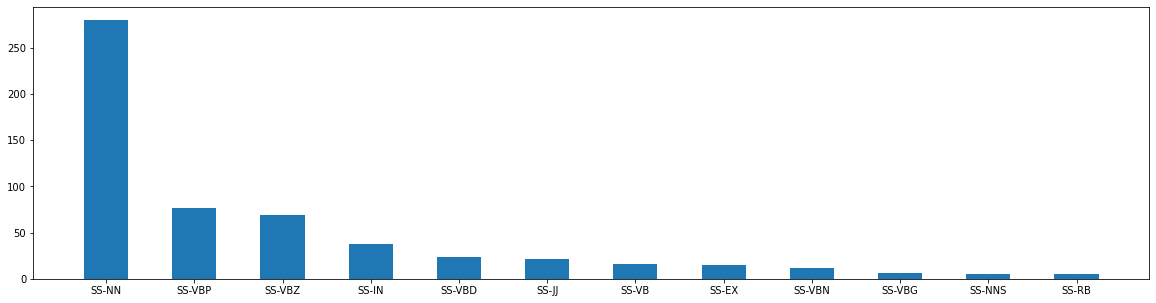

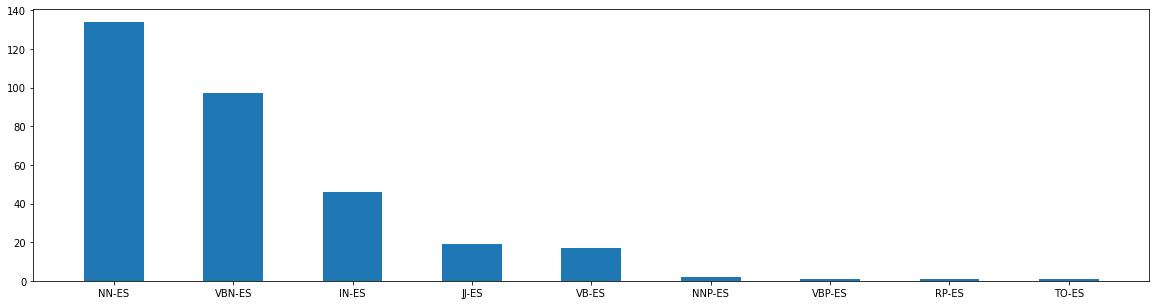

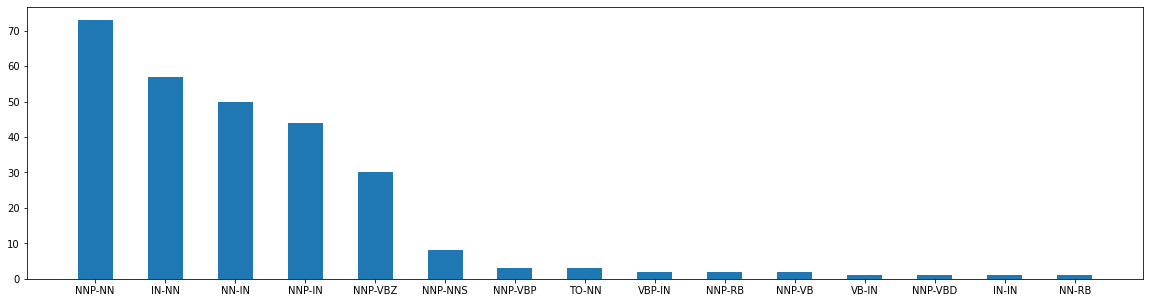

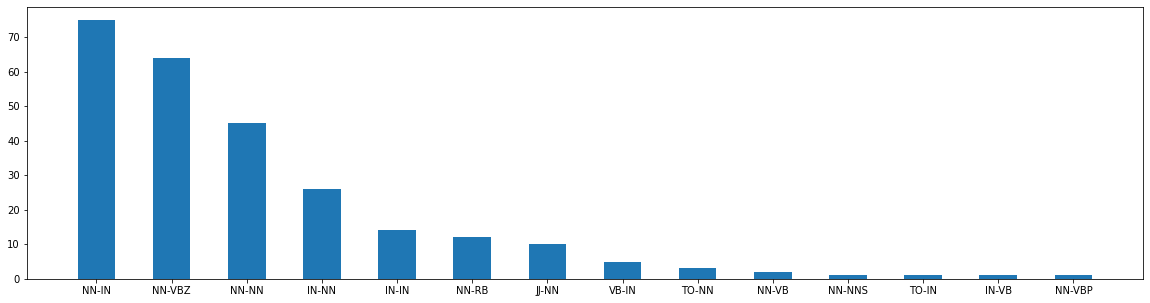

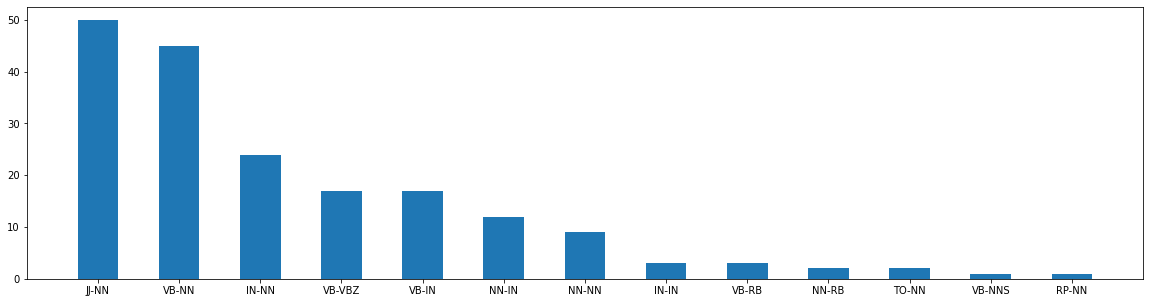

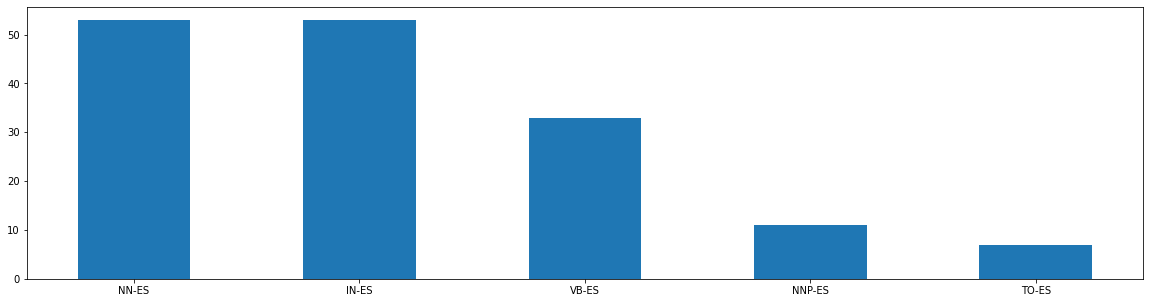

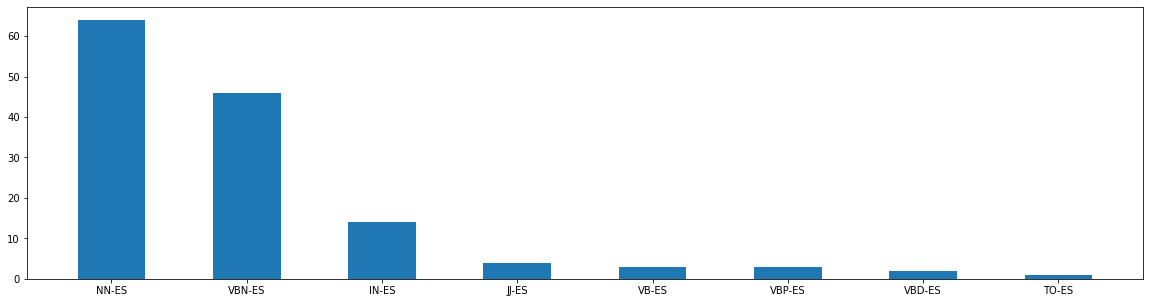

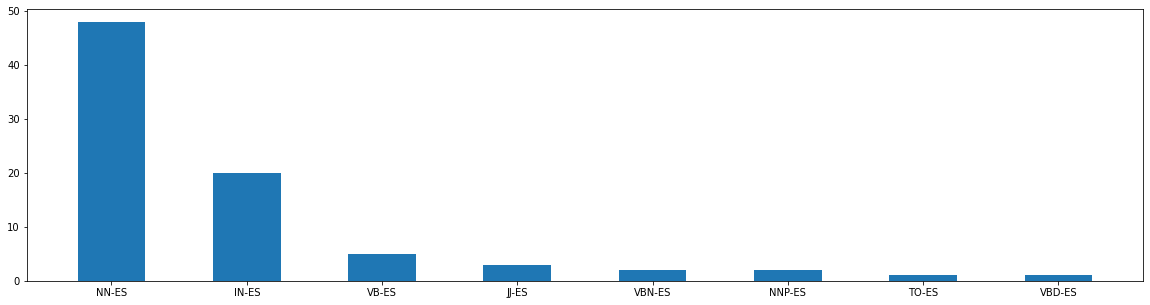

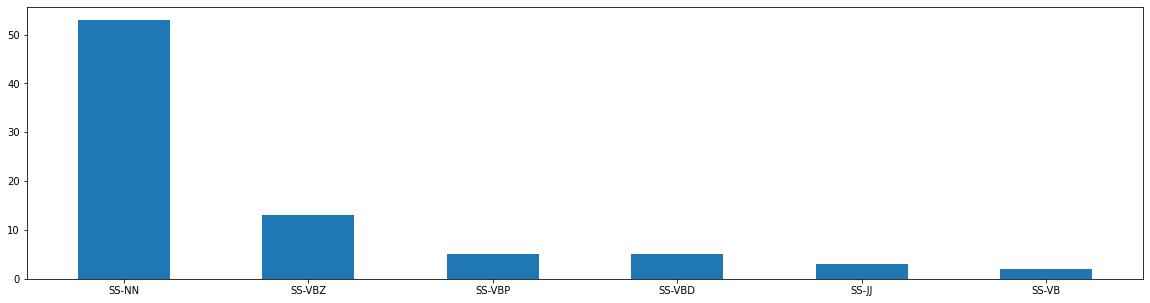

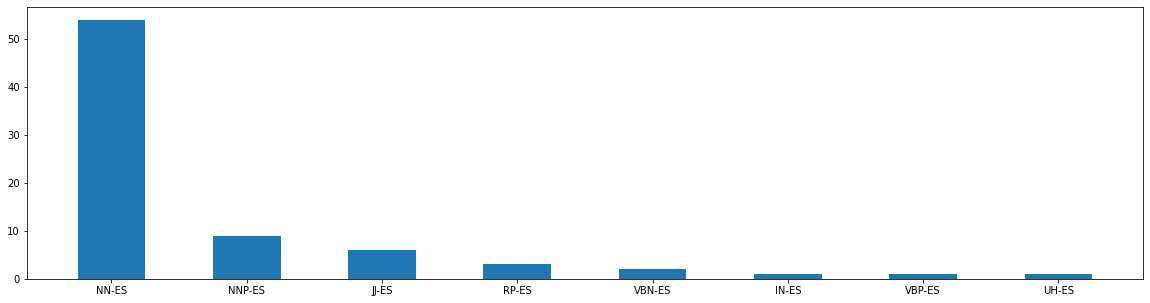

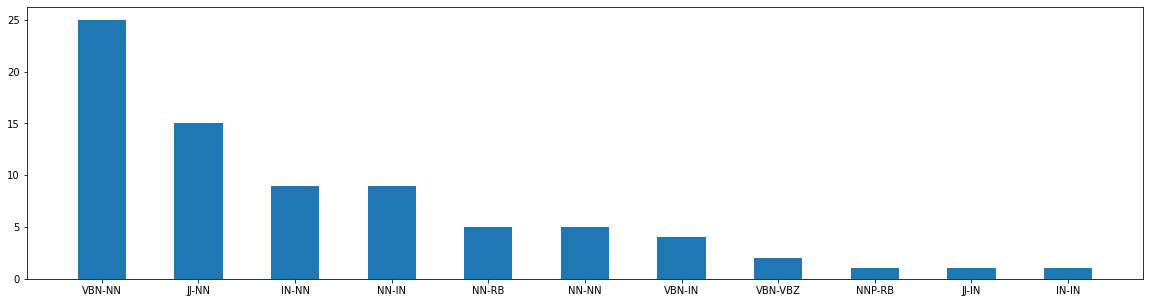

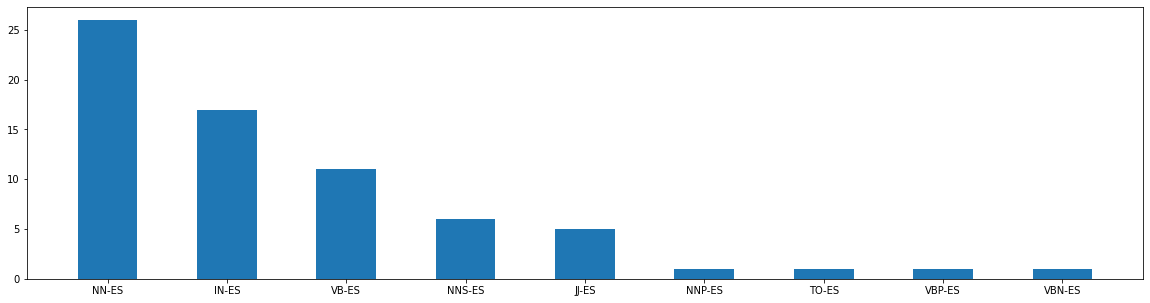

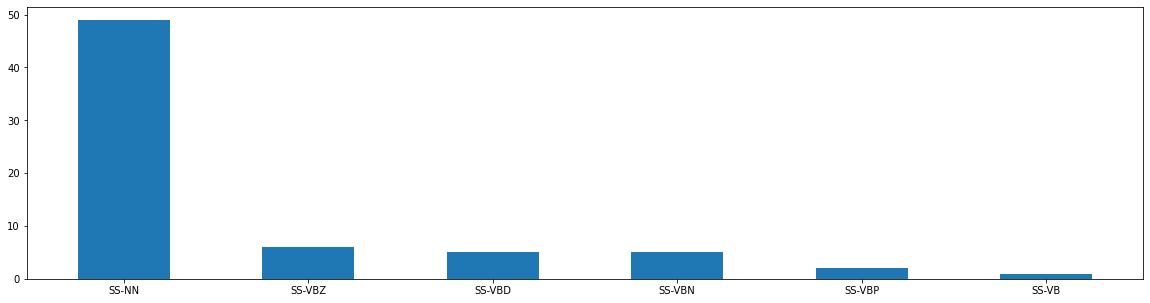

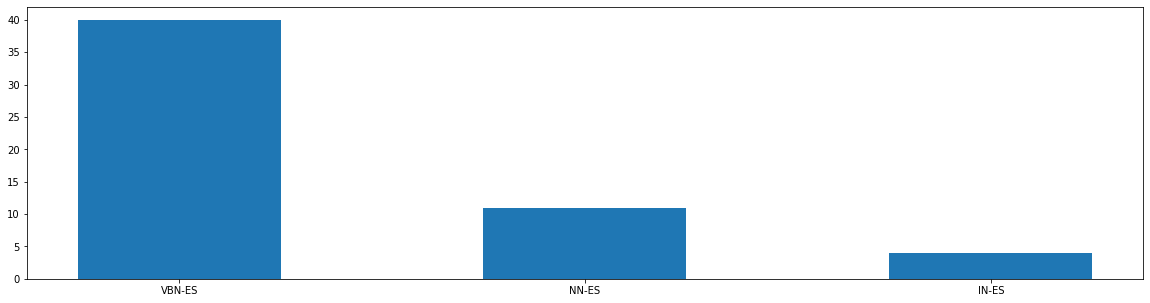

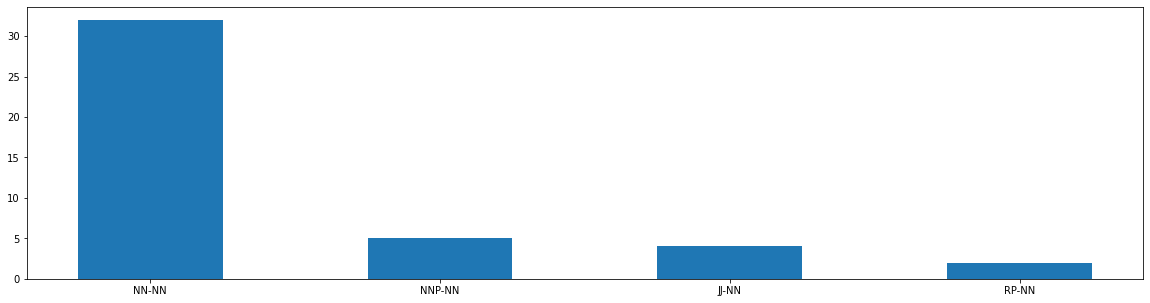

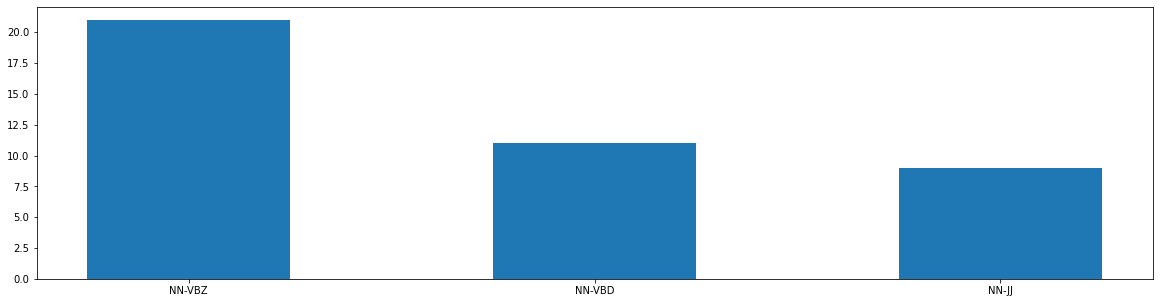

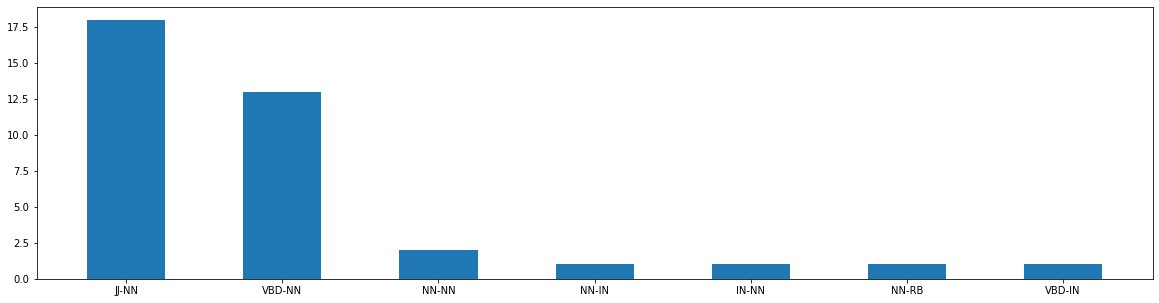

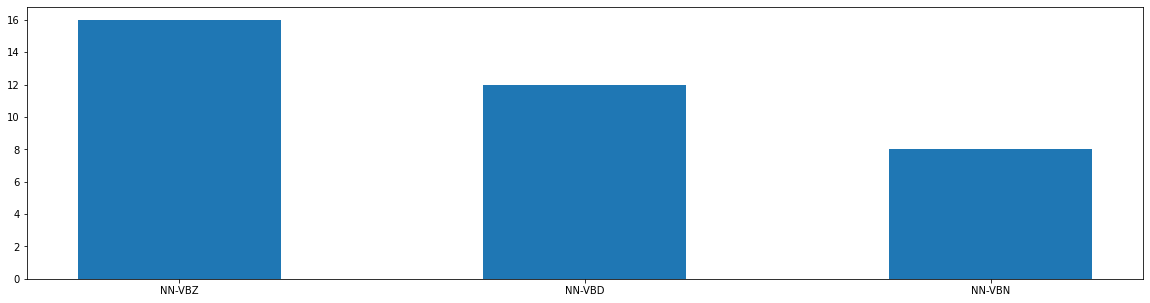

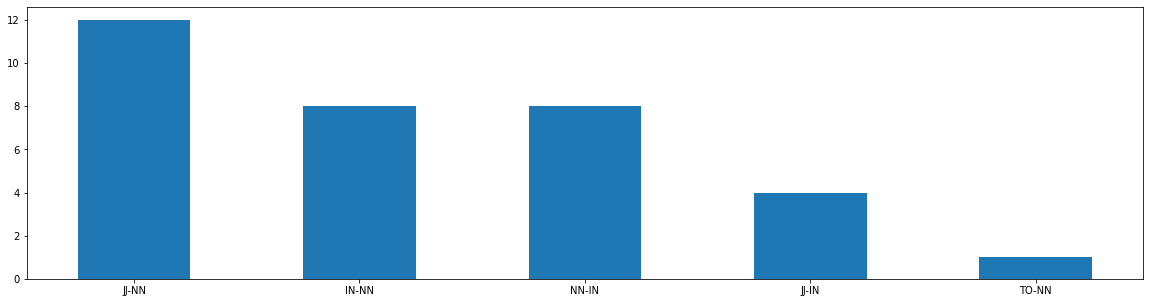

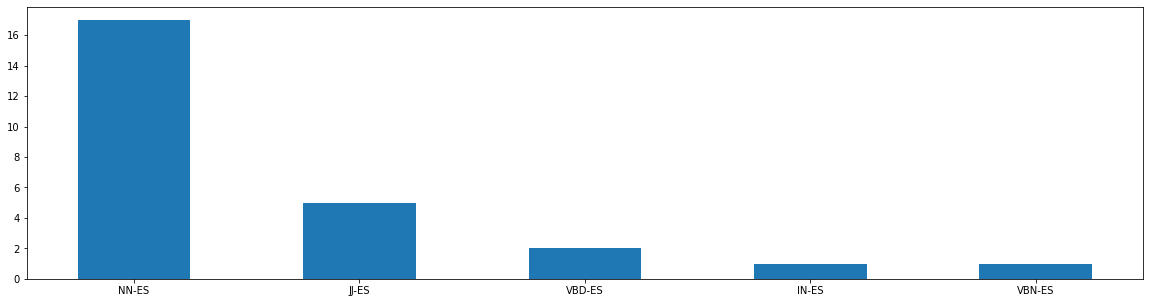

In [16]:
for i in list(first_last_combo_totals.keys())[:20]:
    #sorted dictionary of the text commands where the first and last words in the text command are nouns
    sorted_combo_tag_dict = {k: v for k, v in sorted(first_last_combo_dict[i].items(), key=lambda item: item[1],reverse=True)}
    #visualize the number of text commands with a certain start end POS combo for the above condition
    plt.figure(figsize=(20,5))
    plt.bar(list(sorted_combo_tag_dict.keys()),list(sorted_combo_tag_dict.values()),width=0.5)

In [ ]:
#applys the rule where if the text command starts and ends with a noun then we look for the first instance
#of a noun, then every word after is included in the identifier until a noun, preposition, or verb is found
def IdentifierIdentifier(pos_tagger,text_command):
    sentence = pos_tagger(text_command)
    first_tag = sentence[0].tag_
    last_tag = sentence[-1].tag_
    first_idx = None
    last_idx = None
    identifier_start = False
#     if first_tag == 'NN' and last_tag == 'NN':
#         for i in range(len(sentence)):
#             tag = sentence[i].tag_
#             if identifier_start and (tag == 'IN' or tag == 'VBZ' or tag == 'NN'):
#                 if tag == 'NN':
#                     last_idx = i+1
#                 else:
#                     last_idx = i
#                 break
#             if not identifier_start and tag == 'NN':
#                 first_idx = i
#                 identifier_start = True
    #if first_tag == 'VBN':
    for i in range(len(sentence)):
        tag = sentence[i].tag_
        if i+1 <= len(sentence)-1:
            next_tag = sentence[i+1].tag_
        else:
            next_tag = None
        if (tag == 'IN' and next_tag == 'NN') or ((tag == 'NN' and next_tag == 'IN') or (tag == 'NN' and next_tag == 'VBN')):
            first_idx = i+2
            break
        if (tag == 'NN' or tag == 'IN'):
            first_idx = i+1
            break
    last_idx = len(sentence)
        
    identifier = sentence[first_idx:last_idx]
    return identifier

In [42]:
first_tags = []
last_tags = []
for key in list(first_last_combo_totals.keys())[:20]:
    if key.split('-')[1] == 'ID':
        first_tags.append(key.split('-')[0])
        #last_tags.append(key.split('-')[1])

count = 0
total = 0
for first_tag in first_tags:
    new_df = identifier_pos[(identifier_pos['Last Tag'] == 'ID') & (identifier_pos['First Tag'] == first_tag)]
    total += len(new_df.index.values)
    for i in new_df.index.values:
        text_command = new_df.loc[i][0]
        identifier = new_df.loc[i][1]
        
        predicted_identifier = IdentifierIdentifier(nlp, text_command)
        
        if str(predicted_identifier) == identifier:
            count += 1
    #     else:
    #         print(print_tags(nlp,text_command)[0] + ', '+str(print_tags(nlp,text_command)[1])+', ' + str(predicted_identifier))

    print(count/total) 

0.5331161780673181


In [92]:
tag_combo = {k: v for k, v in sorted(first_last_combo_dict['ID-NN'].items(), key=lambda item: item[1],reverse=True)}
tag_combo

{'SS-NN': 277,
 'SS-VBZ': 68,
 'SS-VBP': 67,
 'SS-IN': 38,
 'SS-VB': 33,
 'SS-VBD': 25,
 'SS-JJ': 24,
 'SS-EX': 15,
 'SS-VBN': 7,
 'SS-VBG': 6,
 'SS-NNS': 5,
 'SS-RB': 4,
 'SS-RP': 1}

In [98]:
threshold = 0.70
threshold_num = round(sum(list(tag_combo.values()))*threshold)
threshold_num

counter_thresh = 0
for tags, count in tag_combo.items():
    counter_thresh += count
    if counter_thresh > threshold_num:
        break
    else:
        

SS-NN 277
SS-VBZ 68
SS-VBP 67
SS-IN 38
SS-VB 33
SS-VBD 25
SS-JJ 24
SS-EX 15
SS-VBN 7
SS-VBG 6
SS-NNS 5
SS-RB 4
SS-RP 1


In [46]:
tmp = new_df[(new_df['Tag Start'] == 'SS') & (new_df['Tag End'] == 'NN')]
tmp

,Text Command,Identifier,Tag Start,Tag End,First Tag,Last Tag


In [47]:
for i in list(list(tmp['Text Command'].values)):
    tmp2 = nlp(i)

    for i in tmp2:
        print(i, i.tag_, ',', end='')
    print('')